In [1]:
import wandb

wandb.login()

wandb: Currently logged in as: liudvikas to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
dataset_folder="dataset_florence"
eval_folder="eval_llava_florence"

In [12]:
!deepspeed LLaVA/llava/train/train_xformers.py \
    --lora_enable True --lora_r 64 --lora_alpha 128 --mm_projector_lr 2e-5 \
    --deepspeed LLaVA/scripts/zero3.json \
    --model_name_or_path liuhaotian/llava-v1.5-7b \
    --version v1 \
    --data_path "./{dataset_folder}/train.json" \
    --image_folder / \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 False \
    --fp16 True \
    --output_dir ./checkpoints/llava-v1.5-7b-lora-florence \
    --num_train_epochs 1 \
    --per_device_train_batch_size 2 \
    --per_device_eval_batch_size 2 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb

[2025-02-02 17:09:41,100] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-02-02 17:09:43,137] [WARNING] [runner.py:202:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2025-02-02 17:09:43,137] [INFO] [runner.py:571:main] cmd = /usr/bin/python3 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMF19 --master_addr=127.0.0.1 --master_port=29500 --enable_each_rank_log=None LLaVA/llava/train/train_xformers.py --lora_enable True --lora_r 64 --lora_alpha 128 --mm_projector_lr 2e-5 --deepspeed LLaVA/scripts/zero3.json --model_name_or_path liuhaotian/llava-v1.5-7b --version v1 --data_path ./dataset_florence/train.json --image_folder / --vision_tower openai/clip-vit-large-patch14-336 --mm_projector_type mlp2x_gelu --mm_vision_select_layer -2 --mm_use_im_start_end False --mm_use_im_patch_token False --image_aspect_ratio pad --group_by_modality_length True --bf16 False --fp16 True --out

In [14]:
import json

def merge_json_files(file_paths):
    """
    Merges multiple JSON files, ensuring no duplicate IDs are included.
    :param file_paths: List of JSON file paths.
    :return: Merged list of unique entries and the count of duplicate IDs.
    """
    data_dict = {}
    duplicate_count = 0
    
    for file_path in file_paths:
        try:
            with open(file_path, "r") as file:
                data = json.load(file)  # Load JSON array
                for entry in data:
                    entry_id = entry["id"]
                    if entry_id in data_dict:
                        duplicate_count += 1  # Count duplicate
                    else:
                        data_dict[entry_id] = entry  # Store unique entry
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return list(data_dict.values()), duplicate_count

# Example usage
file_paths = ["dataset/test.json", "dataset_florence/test.json"]
merged_data, duplicate_count = merge_json_files(file_paths)
print(f"Number of duplicate IDs: {duplicate_count}")
with open("dataset_florence/merged_test.json", "w") as out_file:
    json.dump(merged_data, out_file, indent=4)


Number of duplicate IDs: 8


In [15]:
import json

in_file = f"{dataset_folder}/merged_test.json"     # Replace with your input file
out_file = f"{dataset_folder}/test.jsonl"   # New output file in JSONL format

with open(in_file, "r") as f_in, open(out_file, "w") as f_out:
    data = json.load(f_in)  # This reads the entire array from test.json
    
    for i, item in enumerate(data):

        # We will set question_id to item["id"] if it exists, otherwise fallback to i
        question_id = item.get("id", i)

        # Find the first "human" message in conversations for the question
        text_input = ""
        for conv in item.get("conversations", []):
            if conv.get("from") == "human":
                text_input = conv.get("value", "")
                break

        # Construct a single-line JSON object for the new output
        out_obj = {
            "image": item["image"],
            "text": text_input,
            "question_id": question_id
        }

        # Write to file in JSONL format (one JSON object per line)
        f_out.write(json.dumps(out_obj, ensure_ascii=False) + "\n")

print(f"Converted {in_file} to {out_file} in JSONL format.")


Converted dataset_florence/merged_test.json to dataset_florence/test.jsonl in JSONL format.


In [16]:
# DIFFERENT INFERENCE

!python3 LLaVA/llava/eval/model_vqa.py\
    --model-path "liuhaotian/llava-v1.5-7b" \
    --question-file \
    "{dataset_folder}/test.jsonl" \
    --image-folder \
    / \
    --answers-file \
    "{eval_folder}/pre/ans.jsonl"

[2025-02-02 17:41:11,616] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|                          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.

In [17]:
import json
import re
import pandas as pd

def parse_distance(text):
    """
    Extract the first integer found in the text.
    Adjust this logic depending on how the model
    typically formats its numeric answers.
    """
    match = re.search(r"(\d+)", text)
    if match:
        return int(match.group(1))
    return None

def evaluate_answers(mode="pre"):
    """
    Evaluate answers for either 'pre' or 'after'.
    Loads ground-truth from 'dataset/test.json' and predictions 
    from 'eval_llama/<mode>/ans.jsonl'. 
    Saves a CSV named 'llava_results_<mode>.csv'.

    Parameters:
    -----------
    mode : str
        Either 'pre' or 'after'.
    
    Returns:
    --------
    df : pd.DataFrame
        A pandas DataFrame with the evaluation results.
    """
    if mode not in ["pre", "after"]:
        raise ValueError("Mode must be either 'pre' or 'after'.")

    # Decide file paths based on mode
    ans_jsonl_path = f"{eval_folder}/{mode}/ans.jsonl"
    csv_filename = f"llava_results_{mode}.csv"

    # Load ground-truth data
    test_data_path = f"{dataset_folder}/merged_test.json"
    with open(test_data_path, "r") as f:
        test_data = json.load(f)  # an array of items

    # Load the model answers into a dict:
    #   key = question_id (e.g. "zHTQOrYONrL49SD3ouBwAA_right")
    #   val = predicted text
    answers_dict = {}
    with open(ans_jsonl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            data = json.loads(line)
            qid = data["question_id"]
            answers_dict[qid] = data["text"]

    # We'll track individual errors and build a summary DataFrame
    errors = []
    df_rows = []

    for item in test_data:
        # item example:
        # {
        #   "id": "zHTQOrYONrL49SD3ouBwAA",
        #   "image": "image_file.jpg",
        #   "conversations": [
        #       { "from": "human", "value": "..." },
        #       { "from": "gpt",   "value": "GT answer" }
        #   ]
        # }

        question_id = item["id"]

        if question_id not in answers_dict:
            print(f"Warning: No prediction found for question_id={question_id}")
            continue

        # Ground-truth is the second turn of "conversations"
        ground_truth_str = item["conversations"][1]["value"]
        ground_truth_dist = parse_distance(ground_truth_str)
        if ground_truth_dist is None:
            print(f"Warning: Could not parse distance from GT: {ground_truth_str}")
            continue

        # Model's predicted text from ans.jsonl
        predicted_text = answers_dict[question_id]
        predicted_dist = parse_distance(predicted_text)

        if predicted_dist is None:
            print(f"Warning: Could not parse distance from model output: {predicted_text}")
            continue

        # Compute error
        error = abs(predicted_dist - ground_truth_dist)
        errors.append(error)

        # For logging/printing
        question = item["conversations"][0]["value"]  # the human's question
        print(f"ID: {item['id']}")
        print(f"  Question: {question}")
        print(f"  Ground truth: {ground_truth_dist} meters")
        print(f"  Model answer: {predicted_text}")
        print(f"  Parsed Model answer: {predicted_dist} meters")
        print(f"  Error: {error}\n")

        df_rows.append({
            "id": item["id"],
            "question": question,
            "ground_truth": ground_truth_dist,
            "predicted": predicted_dist,
            "error": error
        })

    # Compute average error
    if len(errors) > 0:
        avg_error = sum(errors) / len(errors)
        print(f"Average error across {len(errors)} samples: {avg_error:.2f} meters")
    else:
        print("No valid predictions found to compute error.")

    # Save to CSV
    df = pd.DataFrame(df_rows)
    df.to_csv(f"{eval_folder}/{mode}/{csv_filename}", index=False)
    print(f"\nResults saved to {csv_filename}")

    return df


In [18]:
evaluate_answers("pre")

ID: zHTQOrYONrL49SD3ouBwAA_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: The bench is approximately 10 meters away from the camera.
  Parsed Model answer: 10 meters
  Error: 1

ID: AugnHJNeLQOFo_kgizi_Og_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: The bench is approximately 10 meters away from the camera, rounded to the next meter.
  Parsed Model answer: 10 meters
  Error: 1

ID: QJeB288kJcLHPPzNjkVtHg_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 21 meters
  Model answer: The bench is approximately 10 meters away from the camera.
  Parsed Model answer: 10 meters
  Error: 11

ID: 4-P_5vju1cJmYjFZVJAA1Q_left
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 13 meters
  Model a

,id,question,ground_truth,predicted,error
0,zHTQOrYONrL49SD3ouBwAA_right,How far is the bench away from the camera in m...,11,10,1
1,AugnHJNeLQOFo_kgizi_Og_right,How far is the bench away from the camera in m...,11,10,1
2,QJeB288kJcLHPPzNjkVtHg_right,How far is the bench away from the camera in m...,21,10,11
3,4-P_5vju1cJmYjFZVJAA1Q_left,How far is the bench away from the camera in m...,13,10,3
4,pP-PfrSj-5XNh3AaWzHyPA_front,How far is the bench away from the camera in m...,16,10,6
...,...,...,...,...,...
464,El9AJPacPimtpFlAoHVfiA_right,How far is the post box away from the camera i...,14,10,4
465,B9GMIBRtDHjs4GmPfNagNA_left,How far is the post box away from the camera i...,22,10,12
466,Z7XH1rQkwcvO-IW8e4hkqw_back,How far is the gas station away from the camer...,18,10,8
467,uZviMwRtEEKJszJuXCsWag_front,How far is the gas station away from the camer...,30,100,70


In [19]:
!python3 LLaVA/scripts/merge_lora_weights.py \
--model-path checkpoints/llava-v1.5-7b-lora-florence \
--model-base liuhaotian/llava-v1.5-7b \
--save-model-path /hpi/fs00/scratch/liudvikas.zekas/llava-ftmodel-florence

[2025-02-02 17:52:20,225] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading LLaVA from base model...
Loading checkpoint shards:   0%|                          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:03<00:00,  1.83s/it]
Loading add

In [20]:
# DIFFERENT INFERENCE

!python3 LLaVA/llava/eval/model_vqa.py\
    --model-path /hpi/fs00/scratch/liudvikas.zekas/llava-ftmodel-yolo \
    --question-file \
    dataset/test.jsonl \
    --image-folder \
    / \
    --answers-file \
    "{eval_folder}/after/ans.jsonl"

[2025-02-02 18:00:51,132] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:24<00:00,  8.22s/it]
Some weights of the model checkpoint at /hpi/fs00/scratch/liudvikas.zekas/llava-ftmodel-yolo were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_mod

In [21]:
evaluate_answers("after")

ID: zHTQOrYONrL49SD3ouBwAA_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: 11 meters
  Parsed Model answer: 11 meters
  Error: 0

ID: AugnHJNeLQOFo_kgizi_Og_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: 10 meters
  Parsed Model answer: 10 meters
  Error: 1

ID: QJeB288kJcLHPPzNjkVtHg_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 21 meters
  Model answer: 11 meters
  Parsed Model answer: 11 meters
  Error: 10

ID: 4-P_5vju1cJmYjFZVJAA1Q_left
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 13 meters
  Model answer: 11 meters
  Parsed Model answer: 11 meters
  Error: 2

ID: pP-PfrSj-5XNh3AaWzHyPA_front
  Question: How far is the bench away from the camera in meters, rounded to the

,id,question,ground_truth,predicted,error
0,zHTQOrYONrL49SD3ouBwAA_right,How far is the bench away from the camera in m...,11,11,0
1,AugnHJNeLQOFo_kgizi_Og_right,How far is the bench away from the camera in m...,11,10,1
2,QJeB288kJcLHPPzNjkVtHg_right,How far is the bench away from the camera in m...,21,11,10
3,4-P_5vju1cJmYjFZVJAA1Q_left,How far is the bench away from the camera in m...,13,11,2
4,pP-PfrSj-5XNh3AaWzHyPA_front,How far is the bench away from the camera in m...,16,12,4
...,...,...,...,...,...
464,El9AJPacPimtpFlAoHVfiA_right,How far is the post box away from the camera i...,14,11,3
465,B9GMIBRtDHjs4GmPfNagNA_left,How far is the post box away from the camera i...,22,11,11
466,Z7XH1rQkwcvO-IW8e4hkqw_back,How far is the gas station away from the camer...,18,11,7
467,uZviMwRtEEKJszJuXCsWag_front,How far is the gas station away from the camer...,30,11,19


Pre summary:
 count    469.000000
mean      47.946695
std       42.308383
min        0.000000
25%        9.000000
50%       71.000000
75%       75.000000
max      379.000000
Name: error, dtype: float64 

After summary:
 count    469.000000
mean      10.701493
std        5.461640
min        0.000000
25%        7.000000
50%       11.000000
75%       15.000000
max       20.000000
Name: error, dtype: float64 



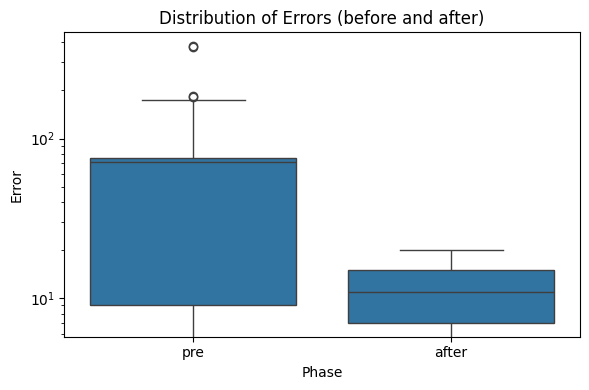

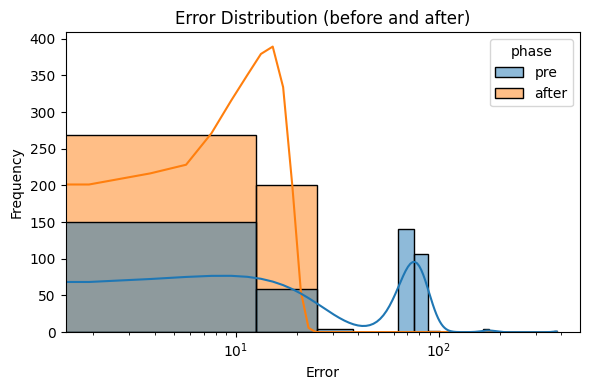

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
df_pre = pd.read_csv(f"{eval_folder}/pre/llava_results_pre.csv")
df_after = pd.read_csv(f"{eval_folder}/after/llava_results_after.csv")

# Add phase labels
df_pre["phase"] = "pre"
df_after["phase"] = "after"

# Combine dataframes
df_combined = pd.concat([df_pre, df_after], ignore_index=True)

# Print summary statistics
print("Pre summary:\n", df_pre["error"].describe(), "\n")
print("After summary:\n", df_after["error"].describe(), "\n")

# Create a boxplot with a logarithmic y-scale
plt.figure(figsize=(6, 4))
sns.boxplot(x="phase", y="error", data=df_combined)
plt.yscale("log")  # Set the y-axis to logarithmic scale
plt.title("Distribution of Errors (before and after)")
plt.ylabel("Error")
plt.xlabel("Phase")
plt.tight_layout()
plt.show()

# Create a histogram with a logarithmic x-scale
plt.figure(figsize=(6, 4))
sns.histplot(data=df_combined, x="error", hue="phase", kde=True)
plt.xscale("log")  # Set the x-axis to logarithmic scale
plt.title("Error Distribution (before and after)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


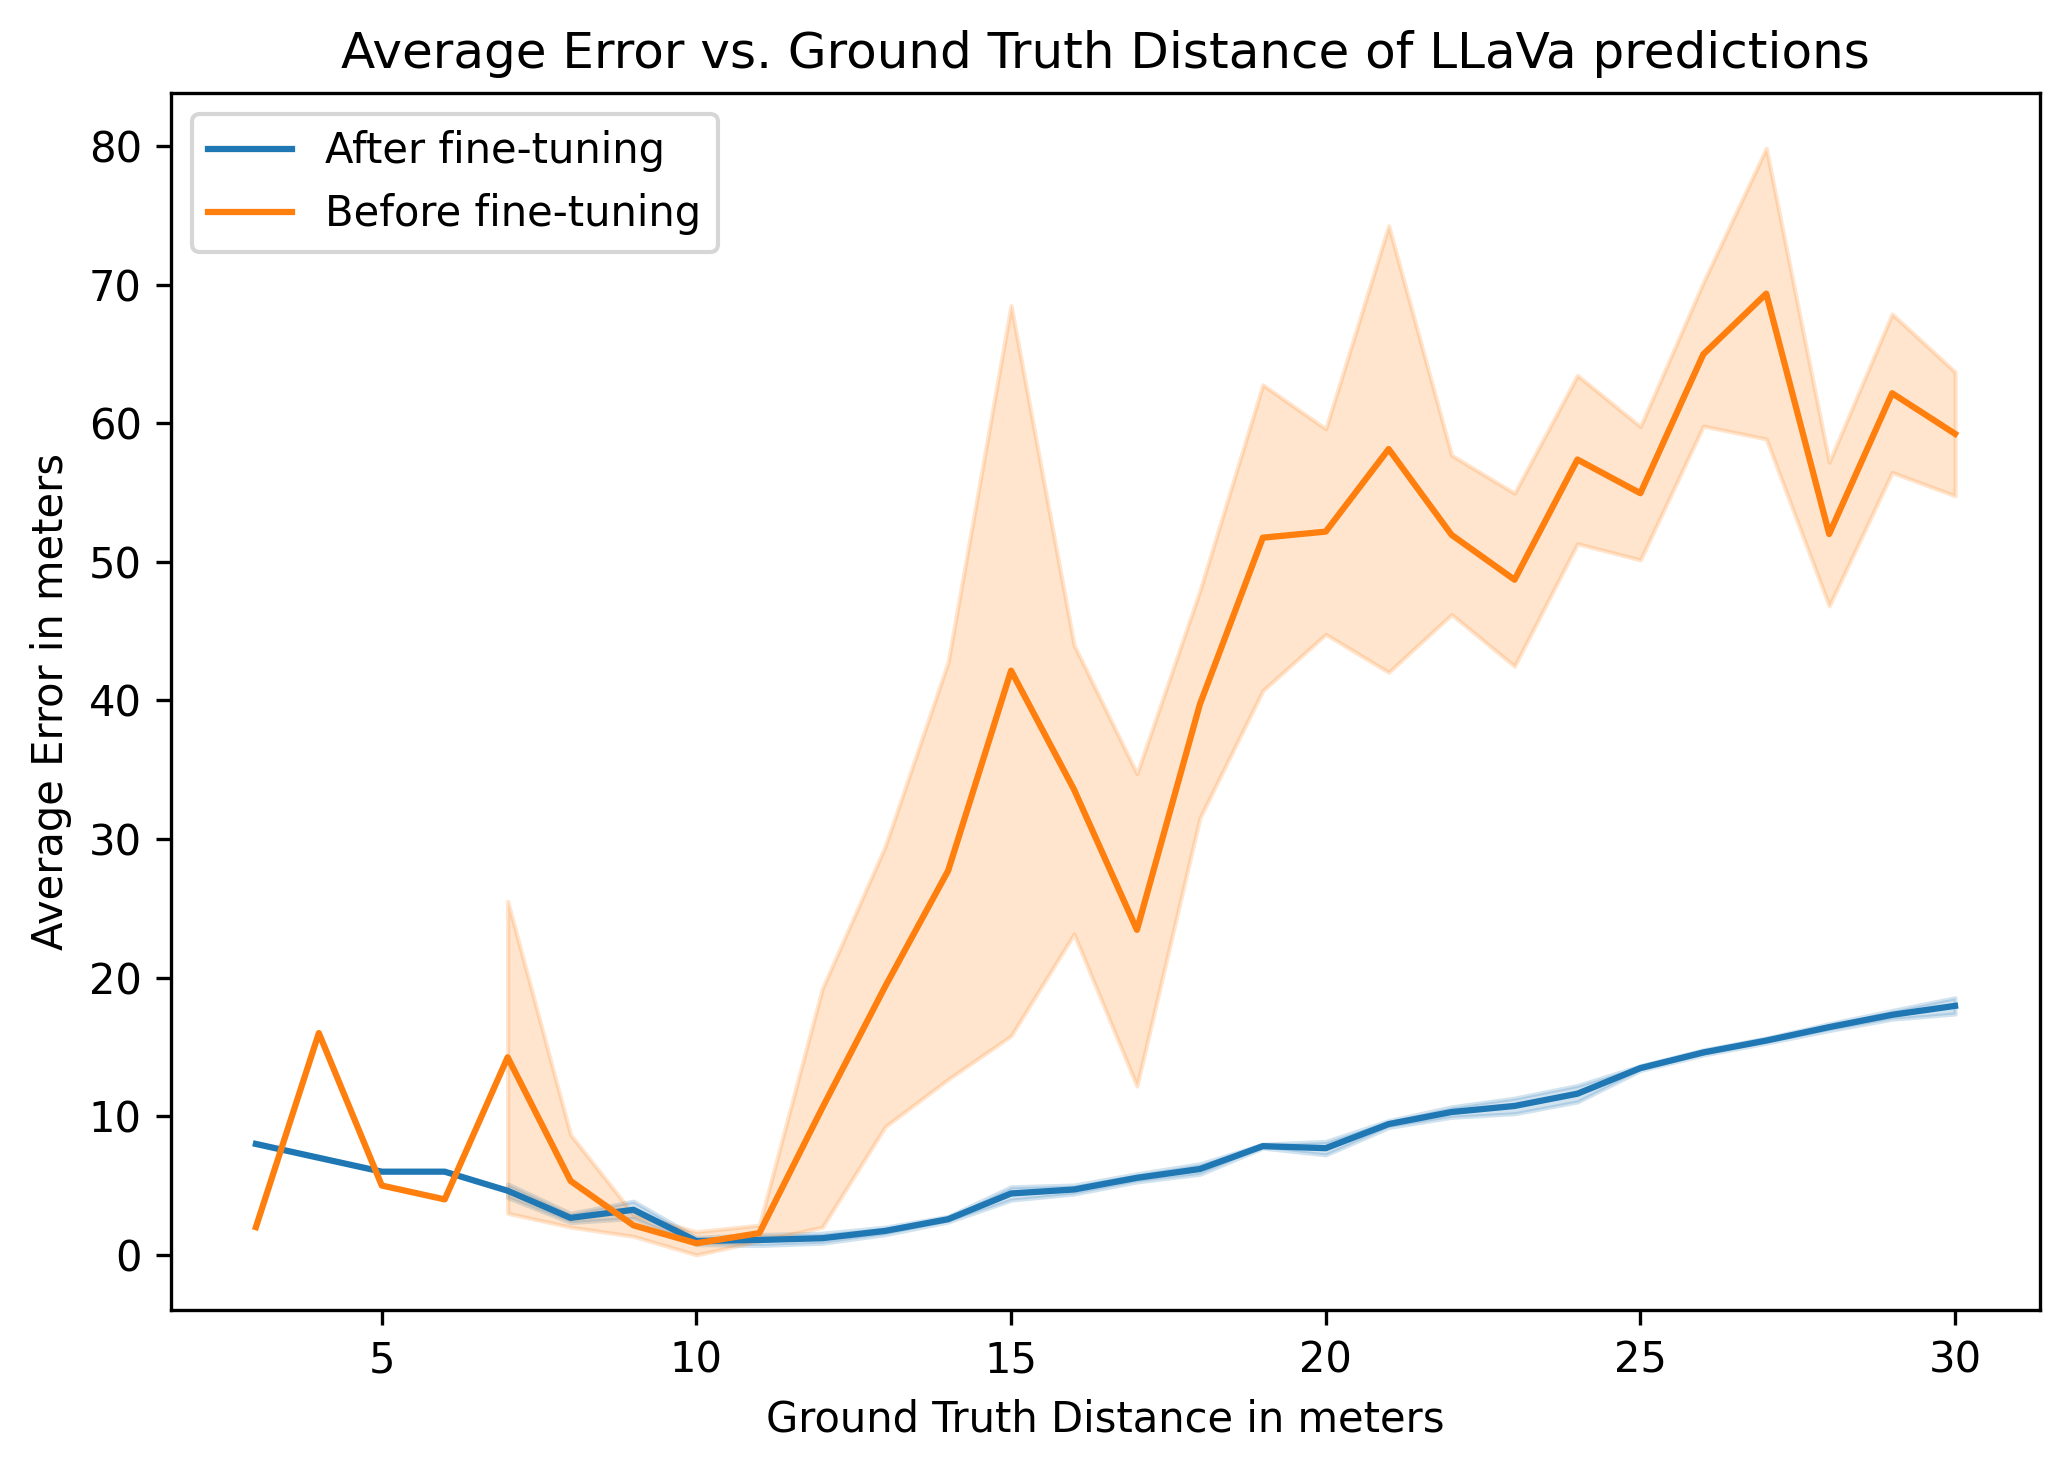

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_pre = pd.read_csv(f"{eval_folder}/pre/llava_results_pre.csv")
df_after = pd.read_csv(f"{eval_folder}/after/llava_results_after.csv")

df_pre["phase"] = "Before fine-tuning"
df_after["phase"] = "After fine-tuning"

df = pd.concat([df_pre, df_after], ignore_index=True)

df = df.sort_values(by="ground_truth")

plt.figure(figsize=(7, 5), dpi=300)
sns.lineplot(
    data=df,
    x="ground_truth", 
    y="error",
    hue="phase",
    estimator="mean",  
    errorbar="se"     
)
plt.title("Average Error vs. Ground Truth Distance of LLaVa predictions")
plt.xlabel("Ground Truth Distance in meters")
plt.ylabel("Average Error in meters")
plt.legend(title="")
plt.tight_layout()
plt.show()
